In [1]:
%cd ../

/workspaces/formula1-season-explorer


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd

from modules.preprocess import make_datamart, add_features, ModelInputData
from modules.utils import load_config
from modules.model import Classifier, Ranker
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

load_dotenv()

BUCKET_NAME = os.environ.get("BUCKET_NAME")
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
DICT_CONFIG = load_config("./config/config.yml")

# Preprocess

In [3]:
df = make_datamart(bucket_name=BUCKET_NAME)
df = add_features(df)


In [4]:
df

,season,round,grandprix,driver,position,q1_sec,q2_sec,q3_sec,q1_sec_fastest,q2_sec_fastest,...,q2_performance_prev4,q2_performance_prev5,q3_performance_prev1,q3_performance_prev2,q3_performance_prev3,q3_performance_prev4,q3_performance_prev5,position_prev_season1,position_prev_season2,position_prev_season3
1464,2009,17,Abu Dhabi,Adrian Sutil,17,101.863,NaN,NaN,99.873,99.695,...,0.138629,0.589457,0.422238,0.332031,NaN,0.231961,NaN,<NA>,<NA>,<NA>
1912,2010,19,Abu Dhabi,Adrian Sutil,13,101.473,100.914,NaN,100.170,99.874,...,3.162153,1.096030,NaN,NaN,NaN,NaN,NaN,17,<NA>,<NA>
2336,2011,18,Abu Dhabi,Adrian Sutil,8,100.595,100.205,100.768,99.782,98.434,...,2.060402,1.561859,NaN,NaN,NaN,NaN,NaN,13,17,<NA>
3215,2013,17,Abu Dhabi,Adrian Sutil,10,102.051,NaN,NaN,100.693,100.473,...,2.215636,1.137216,NaN,NaN,NaN,NaN,NaN,8,13,17
3674,2014,19,Abu Dhabi,Adrian Sutil,16,102.746,103.074,NaN,101.207,100.920,...,2.597095,NaN,NaN,2.855299,NaN,NaN,NaN,10,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103,2023,7,Spain,Zhou Guanyu,9,73.677,73.521,NaN,72.937,72.760,...,NaN,0.931912,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
7605,2024,10,Spain,Zhou Guanyu,13,72.880,72.738,NaN,72.143,71.653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,<NA>
6906,2022,19,United States,Zhou Guanyu,12,96.656,96.970,NaN,95.297,95.246,...,1.256814,1.467227,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
7326,2023,18,United States,Zhou Guanyu,13,96.052,95.698,NaN,95.091,95.004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,<NA>,<NA>


In [5]:
df_features = df.filter(regex="prev", axis=1)
df_context = df.loc[:, ["season", "round", "grandprix", "driver", "position"]]
df_concat = pd.concat([df_context, df_features], axis=1)
df_concat = df_concat[~df_concat["position"].isna()]

In [6]:
df_concat

,season,round,grandprix,driver,position,position_prev1,position_prev2,position_prev3,position_prev4,position_prev5,...,q2_performance_prev4,q2_performance_prev5,q3_performance_prev1,q3_performance_prev2,q3_performance_prev3,q3_performance_prev4,q3_performance_prev5,position_prev_season1,position_prev_season2,position_prev_season3
1464,2009,17,Abu Dhabi,Adrian Sutil,17,<NA>,13,<NA>,4,11,...,0.138629,0.589457,0.422238,0.332031,NaN,0.231961,NaN,<NA>,<NA>,<NA>
1912,2010,19,Abu Dhabi,Adrian Sutil,13,12,<NA>,<NA>,9,16,...,3.162153,1.096030,NaN,NaN,NaN,NaN,NaN,17,<NA>,<NA>
2336,2011,18,Abu Dhabi,Adrian Sutil,8,9,11,11,8,<NA>,...,2.060402,1.561859,NaN,NaN,NaN,NaN,NaN,13,17,<NA>
3215,2013,17,Abu Dhabi,Adrian Sutil,10,9,14,20,10,16,...,2.215636,1.137216,NaN,NaN,NaN,NaN,NaN,8,13,17
3674,2014,19,Abu Dhabi,Adrian Sutil,16,16,<NA>,16,21,<NA>,...,2.597095,NaN,NaN,2.855299,NaN,NaN,NaN,10,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103,2023,7,Spain,Zhou Guanyu,9,13,16,<NA>,9,13,...,NaN,0.931912,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
7605,2024,10,Spain,Zhou Guanyu,13,15,16,15,14,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,<NA>
6906,2022,19,United States,Zhou Guanyu,12,16,<NA>,10,16,14,...,1.256814,1.467227,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
7326,2023,18,United States,Zhou Guanyu,13,9,13,12,14,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,<NA>,<NA>


# Classifier

## Train model

In [7]:
data_test = df_concat[df_concat["season"] > 2023]
data_training = df_concat[df_concat["season"] <= 2023]
data_train, data_valid = train_test_split(data_training, test_size=0.3, random_state=42)

In [8]:
X_train = data_train.loc[:, df_features.columns]
X_valid = data_valid.loc[:, df_features.columns]
y_train = data_train["position"] == 1
y_valid = data_valid["position"] == 1

X_test = data_test.loc[:, df_features.columns]
y_test = data_test["position"] == 1

classifier = Classifier(
    bucket_name=BUCKET_NAME,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    s3_model_key=DICT_CONFIG["s3_model_key"],
)

classifier.train(X_train, X_valid, y_train, y_valid)

y_pred = classifier.predict(X_test)

df_check = data_test.copy()
df_check["pred"] = y_pred

[LightGBM] [Info] Number of positive: 252, number of negative: 4014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4023
[LightGBM] [Info] Number of data points in the train set: 4266, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.906957


In [9]:
pd.set_option("display.max_rows", 100)

df_check.loc[df_check["pred"]>0.5, ["season", "round", "grandprix", "driver", "position", "pred"]].sort_values(by=["season", "round", "pred"], ascending=[True, True, False]).groupby(["season", "round"]).head(10)

,season,round,grandprix,driver,position,pred
7423,2024,1,Bahrain,Lance Stroll,10,0.768682
7420,2024,1,Bahrain,Lewis Hamilton,7,0.715558
7417,2024,1,Bahrain,Charles Leclerc,4,0.682995
7432,2024,1,Bahrain,Valtteri Bottas,19,0.665767
7414,2024,1,Bahrain,Max Verstappen,1,0.611824
7415,2024,1,Bahrain,Sergio Perez,2,0.611824
7416,2024,1,Bahrain,Carlos Sainz,3,0.603600
7434,2024,2,Saudi Arabia,Max Verstappen,1,0.905376
7435,2024,2,Saudi Arabia,Sergio Perez,2,0.883790
7438,2024,2,Saudi Arabia,Fernando Alonso,5,0.815338


## Evaluate
- Adhoc check of trained models
- This is only in notebook

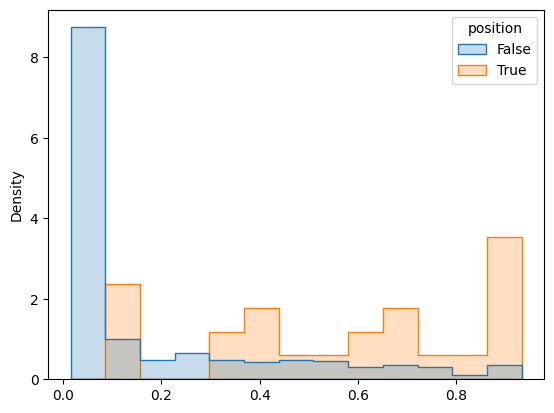

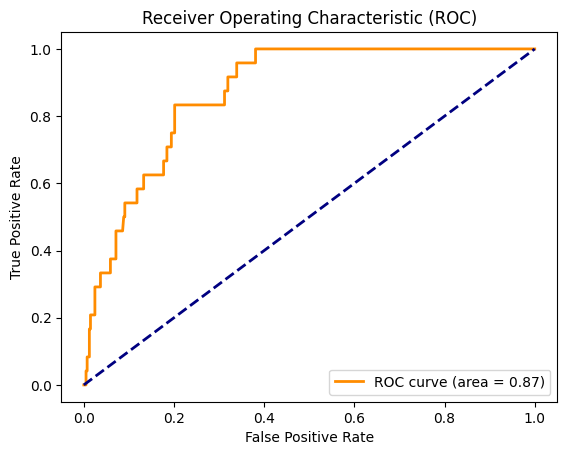

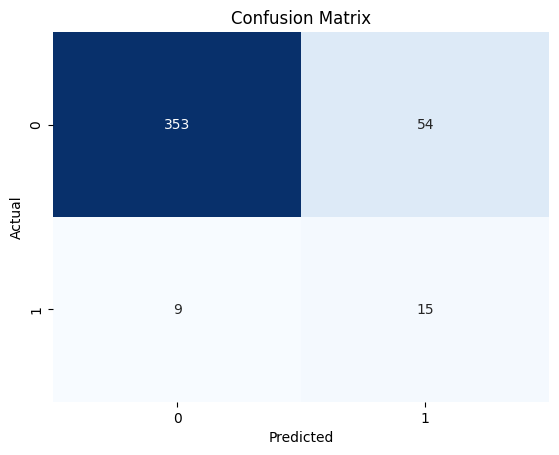

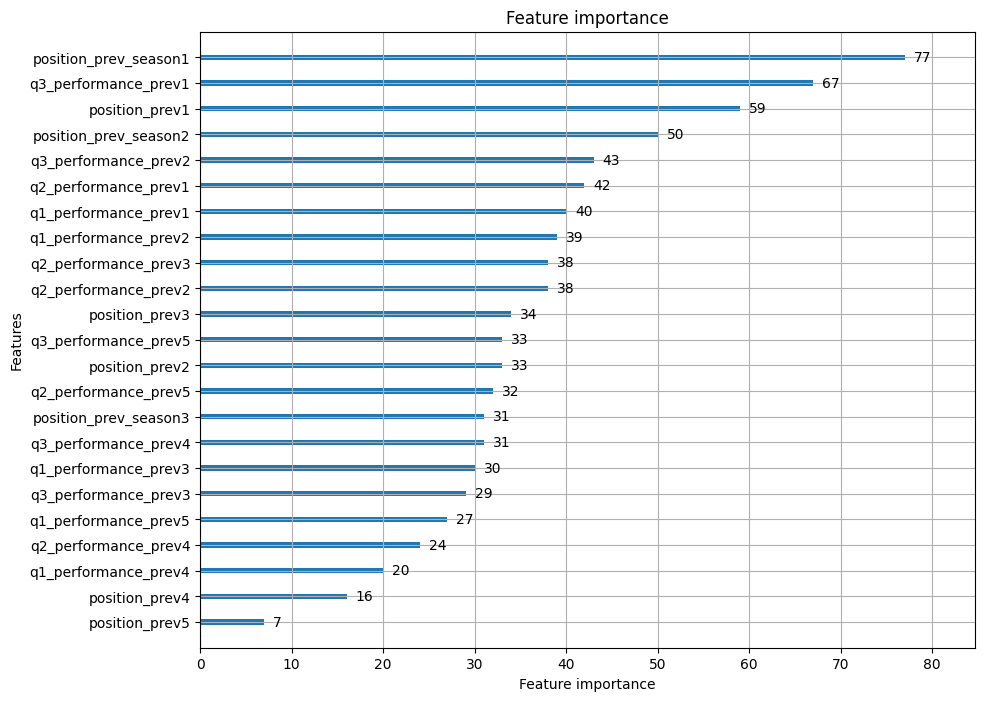

In [10]:
# How well the model is predicting
sns.histplot(x=y_pred, hue=y_test, element="step", stat="density", common_norm=False)


# Area Under the Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
matrix = confusion_matrix(y_test, np.round(y_pred))

plt.figure()
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature importance
lgb.plot_importance(classifier.model, figsize=(10, 8))
plt.show()

## Save model to S3

In [11]:
classifier.save_model()

## Load model from S3 and Predict

In [12]:
classifier_2 = Classifier(
    bucket_name=BUCKET_NAME,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    s3_model_key=DICT_CONFIG["s3_model_key"],
)

classifier_2.load_model()

y_pred_2 = classifier_2.predict(X_test)

# Ranker

## Train

In [17]:
df_concat_rank = df_concat.copy()
df_concat_rank.sort_values(by=["season", "round"], inplace=True)

data_training = df_concat_rank.loc[df_concat_rank["season"] <= 2023]
data_test = df_concat_rank.loc[df_concat_rank["season"] > 2023]

list_train_year = np.random.choice(data_training["season"].unique(), int(data_training["season"].nunique() * 0.8), replace=False)
data_train = data_training.loc[data_training["season"].isin(list_train_year)]
data_valid = data_training.loc[~data_training["season"].isin(list_train_year)]

data_train.reset_index(drop=True, inplace=True)
data_valid.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [18]:
X_train = data_train[df_features.columns]
X_valid = data_valid[df_features.columns]
y_train = data_train["position"] - 1
y_valid = data_valid["position"] - 1

X_test = data_test[df_features.columns]
y_test = data_test["position"] - 1

query_train = data_train.groupby(["season", "round"]).size().to_numpy()
query_valid = data_valid.groupby(["season", "round"]).size().to_numpy()
query_test = data_test.groupby(["season", "round"]).size().to_numpy()

ranker = Ranker(
    bucket_name=BUCKET_NAME,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    s3_model_key=DICT_CONFIG["s3_model_key"],
)
ranker.train(X_train, X_valid, y_train, y_valid, query_train, query_valid)


y_pred = ranker.predict(X_test, query_test)

df_check = data_test.copy()
df_check["pred"] = y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4024
[LightGBM] [Info] Number of data points in the train set: 4696, number of used features: 23
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's ndcg@3: 0.586943	valid_0's ndcg@10: 0.707683


In [19]:
df_check.loc[df_check["season"]==2024, ["grandprix", "season", "round", "driver", "position", "pred"]].sort_values(by=["round", "pred"], ascending=[True, True]).groupby(["round"]).head(3)

,grandprix,season,round,driver,position,pred
8,Bahrain,2024,1,Lance Stroll,10,1.0
16,Bahrain,2024,1,Sergio Perez,2,2.0
6,Bahrain,2024,1,George Russell,5,3.0
30,Saudi Arabia,2024,2,Max Verstappen,1,1.0
21,Saudi Arabia,2024,2,Charles Leclerc,3,2.0
25,Saudi Arabia,2024,2,George Russell,6,3.0
51,Australia,2024,3,Sergio Perez,5,1.0
40,Australia,2024,3,Charles Leclerc,2,2.0
43,Australia,2024,3,Fernando Alonso,8,3.0
55,Japan,2024,4,Carlos Sainz,3,1.0


## Evaluate

In [20]:
import seaborn as sns
from sklearn.metrics import ndcg_score

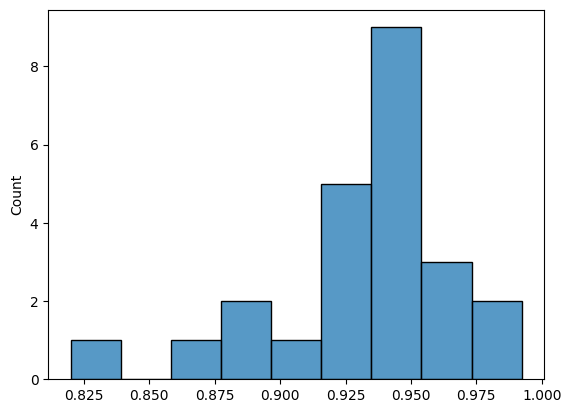

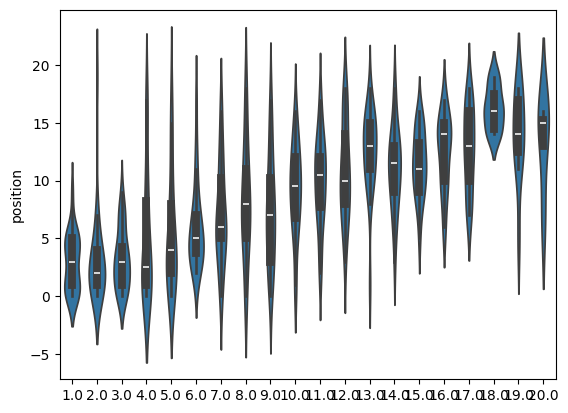

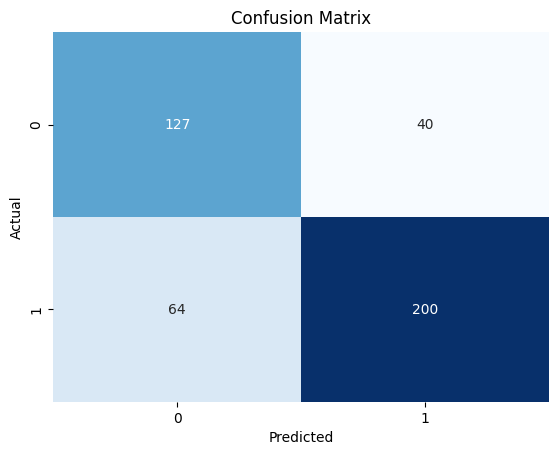

In [21]:
# NDCG distribution for each query
ndcg = []
current_idx = 0
for idx, query in enumerate(query_test):
    ndcg.append(
        ndcg_score(
            y_test.iloc[current_idx : current_idx + query].values.reshape(1, -1),
            y_pred[current_idx : current_idx + query].reshape(1, -1),
        )
    )
    current_idx += query

sns.histplot(ndcg)
plt.show()

# Relation between prediction and position
sns.violinplot(x=y_pred, y=y_test)
plt.show()


# Confusion Matrix for top 10
matrix = confusion_matrix(y_test <= 10, y_pred <= 10)
plt.figure()
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Save model to S3

In [22]:
ranker.save_model()

## Load model and predict

In [23]:
ranker_2 = Ranker(
    bucket_name=BUCKET_NAME,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    s3_model_key=DICT_CONFIG["s3_model_key"],
)

ranker_2.load_model()

In [24]:
# If you predict only a round, query is not needed for predict
y_pred_2 = ranker_2.predict(X_test.iloc[-20:])

In [25]:
y_pred_2

array([18, 13, 19, 15,  2,  3,  8,  5, 20, 16, 14,  4, 11, 12,  1, 10,  7,
        9,  6, 17])

In [28]:
ranker.predict(X_test.iloc[-20:])

array([18, 13, 19, 15,  2,  3,  8,  5, 20, 16, 14,  4, 11, 12,  1, 10,  7,
        9,  6, 17])

In [31]:
ranker_2.model.feature_name_

['position_prev1',
 'position_prev2',
 'position_prev3',
 'position_prev4',
 'position_prev5',
 'q1_performance_prev1',
 'q1_performance_prev2',
 'q1_performance_prev3',
 'q1_performance_prev4',
 'q1_performance_prev5',
 'q2_performance_prev1',
 'q2_performance_prev2',
 'q2_performance_prev3',
 'q2_performance_prev4',
 'q2_performance_prev5',
 'q3_performance_prev1',
 'q3_performance_prev2',
 'q3_performance_prev3',
 'q3_performance_prev4',
 'q3_performance_prev5',
 'position_prev_season1',
 'position_prev_season2',
 'position_prev_season3']